This notebook shows the process to extract the ROI (1.35km x 1.35km squared image centered on the site) from Sentinel-2 raw images. Meanwhile the calculation of NIRV reflectance is calculated and therefore the output image will only contain the values of NIRV reflactance. 

In [1]:
import os
# import math
import numpy as np
import shapely as shp
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio as rio
import rasterio.mask

In [2]:
cwd = "c:\\Users\\m1865\\Desktop\\DISC"
cwd_Images_Raw = cwd + "\\Sentinel-2 Images Raw (Replication)"
cwd_Images_Processed = cwd + "\\Sentinel-2 Images Processed (Replication)"

### 1. Read all the Sentinel-2 raw images

In [3]:
# Get the names of the folders in the raw image directory
list_Raw_Name = ['Havard Forest']

In [4]:
# Get paths to all the 10m-resolution .jp2 files
list_Raw_10m = []
for raw_Name in list_Raw_Name:
    # Create a temporary list to store the paths to all the 10m-resolution .jp2
    temp_List = []
    # Find all the files under the directory and filter out those irrelevant
    for path, subdirs, files in os.walk(cwd_Images_Raw + "\\" + raw_Name + "\\L2A"):
        for name in files:
            temp = os.path.join(path, name)
            if temp[-3:] == 'jp2' and "B0" in temp and "10m" in temp:
                # print(temp)
                temp_List.append(temp)
    list_Raw_10m.append(temp_List)
del raw_Name, temp_List
list_Raw_10m[0]

['c:\\Users\\m1865\\Desktop\\DISC\\Sentinel-2 Images Raw (Replication)\\Havard Forest\\L2A\\S2B_MSIL2A_20170806T153909_N0500_R011_T18TYN_20230930T211846.SAFE\\GRANULE\\L2A_T18TYN_A002182_20170806T153908\\IMG_DATA\\R10m\\T18TYN_20170806T153909_B02_10m.jp2',
 'c:\\Users\\m1865\\Desktop\\DISC\\Sentinel-2 Images Raw (Replication)\\Havard Forest\\L2A\\S2B_MSIL2A_20170806T153909_N0500_R011_T18TYN_20230930T211846.SAFE\\GRANULE\\L2A_T18TYN_A002182_20170806T153908\\IMG_DATA\\R10m\\T18TYN_20170806T153909_B03_10m.jp2',
 'c:\\Users\\m1865\\Desktop\\DISC\\Sentinel-2 Images Raw (Replication)\\Havard Forest\\L2A\\S2B_MSIL2A_20170806T153909_N0500_R011_T18TYN_20230930T211846.SAFE\\GRANULE\\L2A_T18TYN_A002182_20170806T153908\\IMG_DATA\\R10m\\T18TYN_20170806T153909_B04_10m.jp2',
 'c:\\Users\\m1865\\Desktop\\DISC\\Sentinel-2 Images Raw (Replication)\\Havard Forest\\L2A\\S2B_MSIL2A_20170806T153909_N0500_R011_T18TYN_20230930T211846.SAFE\\GRANULE\\L2A_T18TYN_A002182_20170806T153908\\IMG_DATA\\R10m\\T18TYN_20

In [5]:
# Read them via rasterio package
list_Image_10m = []
for item in list_Raw_10m[0]:
    temp = rio.open(item)
    list_Image_10m.append(temp)
list_Image_10m[2]

<open DatasetReader name='c:/Users/m1865/Desktop/DISC/Sentinel-2 Images Raw (Replication)/Havard Forest/L2A/S2B_MSIL2A_20170806T153909_N0500_R011_T18TYN_20230930T211846.SAFE/GRANULE/L2A_T18TYN_A002182_20170806T153908/IMG_DATA/R10m/T18TYN_20170806T153909_B04_10m.jp2' mode='r'>

In [6]:
# Get the 2d array by reading the band
list_Band_10m = []
for item in list_Image_10m:
    temp = item.read(1)
    list_Band_10m.append(temp)
list_Band_10m[2]

array([[1314, 1496, 1682, ..., 1586, 1370, 1188],
       [1296, 1361, 1468, ..., 1718, 1476, 1241],
       [1278, 1325, 1326, ..., 1758, 1530, 1284],
       ...,
       [1219, 1210, 1223, ..., 1481, 1319, 1368],
       [1234, 1231, 1226, ..., 1666, 1396, 1522],
       [1212, 1236, 1222, ..., 1906, 1474, 1668]], dtype=uint16)

### 2. Read sites information

In [7]:
df_Sites = pd.DataFrame({
    "Site": ['Havard Forest'],
    "Latitude": [42.538],
    "Longitude": [-72.171]
})
df_Sites

,Site,Latitude,Longitude
0,Havard Forest,42.538,-72.171


### 3. Create a shapefile of the site Havard

In [8]:
# Create a point shapefile based on the site, using Lon-Lat
gdf_4326 = gpd.GeoDataFrame(
    df_Sites,
    geometry = gpd.points_from_xy(df_Sites['Longitude'], df_Sites['Latitude']),
    crs = "EPSG:4326"
)
gdf_4326

,Site,Latitude,Longitude,geometry
0,Havard Forest,42.538,-72.171,POINT (-72.17100 42.53800)


In [9]:
# Check the crs of Sentinel-2 images
list_Image_10m[2].crs

CRS.from_epsg(32618)

In [10]:
# In case the convertion of CRS of a raster by using rasterio
# from rasterio.crs import CRS
# raster_new = raster.rio.reproject(CRS.from_string('EPSG:4326'))

In [11]:
# Converting Lon-Lat to UTM coordinates!
# Attention that the CRS in USA for meter unit is 32618!!! Not 32632!!! 
gdf_32618 = gdf_4326.copy()
gdf_32618 = gdf_32618.to_crs('EPSG:32618')
gdf_32618

,Site,Latitude,Longitude,geometry
0,Havard Forest,42.538,-72.171,POINT (732315.443 4713391.751)


In [12]:
gdf_4326.to_file(cwd_Images_Processed + "\\Havard\\shp_Havard_4326.shp")
gdf_4326.to_file(cwd_Images_Processed + "\\Havard\\shp_Havard_4326.json", driver = "GeoJSON")
gdf_32618.to_file(cwd_Images_Processed + "\\Havard\\shp_Havard_32618.shp")
gdf_32618.to_file(cwd_Images_Processed + "\\Havard\\shp_Havard_32618.json", driver = "GeoJSON")

### 4. Assign the site to a pixel, and then create a 1000m2, 1.5km2 and 2000m2 square geodataframe

In [13]:
# Check the bounds of Sentinel-2 images first
list_Image_10m[2].bounds

BoundingBox(left=699960.0, bottom=4690200.0, right=809760.0, top=4800000.0)

In [14]:
# First we retrieve the x, y coordinate of our site
site_x = gdf_32618.geometry.x.values[0]
site_y = gdf_32618.geometry.y.values[0]
print("Site X, Y: " + str(site_x) + "," + str(site_y))

Site X, Y: 732315.442750216,4713391.750567996


In [15]:
# Then we get the row, col of our site in the raster, so that we know the pixel the site belongs to
site_row, site_col = list_Image_10m[2].index(site_x, site_y)
print("Site falls on the pixel: " + str(site_row) + ", " + str(site_col))

Site falls on the pixel: 8660, 3235


In [16]:
# Now we get the spatial coordinates of that pixel (coordinates of its center)
site_pixel_x, site_pixel_y = list_Image_10m[2].xy(site_row, site_col)
print("The spatial coordinates of the (center) pixel which the site falls on is: " + str(site_pixel_x) + ", " + str(site_pixel_y))

The spatial coordinates of the (center) pixel which the site falls on is: 732315.0, 4713395.0


In [29]:
# Get the coordinates of the four corners
site_x_left_1000m = site_pixel_x - 505
site_x_right_1000m = site_pixel_x + 505
site_y_top_1000m = site_pixel_y + 505
site_y_bottom_1000m = site_pixel_y - 505
# 1.5km 
site_x_left_1500m = site_pixel_x - 755
site_x_right_1500m = site_pixel_x + 755
site_y_top_1500m = site_pixel_y + 755
site_y_bottom_1500m = site_pixel_y - 755
# 2000m
site_x_left_2000m = site_pixel_x - 1005
site_x_right_2000m = site_pixel_x + 1005
site_y_top_2000m = site_pixel_y + 1005
site_y_bottom_2000m = site_pixel_y - 1005
# 18000 m
site_x_left_18000m = site_pixel_x - 9005
site_x_right_18000m = site_pixel_x + 9005
site_y_top_18000m = site_pixel_y + 9005
site_y_bottom_18000m = site_pixel_y - 9005

In [30]:
# Now we need to form a 1-km square shapefile, which will be the internal area of which we will evaluate the spatial representativeness. 
shp_1000m = shp.box(site_x_left_1000m, site_y_bottom_1000m, site_x_right_1000m, site_y_top_1000m)
gdf_1000m = gpd.GeoDataFrame(
    [1],
    geometry=[shp_1000m],
    crs = "EPSG:32618"
)
gdf_1000m.area

0    1020100.0
dtype: float64

In [31]:
shp_1500m = shp.box(site_x_left_1500m, site_y_bottom_1500m, site_x_right_1500m, site_y_top_1500m)
gdf_1500m = gpd.GeoDataFrame(
    [1],
    geometry=[shp_1500m],
    crs = "EPSG:32618"
)
shp_2000m = shp.box(site_x_left_2000m, site_y_bottom_2000m, site_x_right_2000m, site_y_top_2000m)
gdf_2000m = gpd.GeoDataFrame(
    pd.DataFrame({"0":["0"]}),
    geometry=[shp_2000m],
    crs = "EPSG:32618"
)
shp_18000m = shp.box(site_x_left_18000m, site_y_bottom_18000m, site_x_right_18000m, site_y_top_18000m)
gdf_18000m = gpd.GeoDataFrame(
    pd.DataFrame({"0":["0"]}),
    geometry=[shp_18000m],
    crs = "EPSG:32618"
)

In [32]:
gdf_2000m.to_file(cwd_Images_Processed + "//Havard//2000m.shp")
gdf_18000m.to_file(cwd_Images_Processed + "//Havard//18000m.shp")

Text(0.5, 1.0, '1000m Square (Internal Area)')

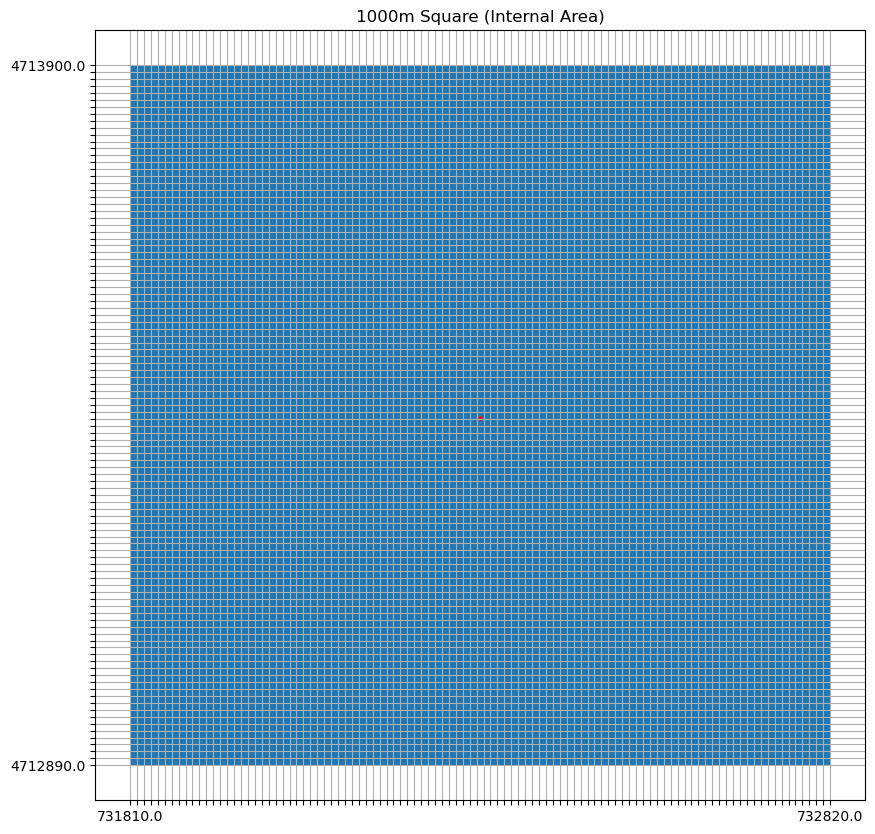

In [20]:
# Plot to check!
fig, ax = plt.subplots(figsize = (10,10))
gdf_1000m.plot(ax = ax)
gdf_32618.plot(ax = ax, color = 'red', markersize = 5)
ax.set_xticks(np.arange(site_x_left_1000m, site_x_right_1000m + 10, 10))
ax.set_yticks(np.arange(site_y_bottom_1000m, site_y_top_1000m + 10, 10))
ax.set_xticklabels([tick if tick == site_x_left_1000m or tick == site_x_right_1000m else None for tick in ax.get_xticks()])
ax.set_yticklabels([tick if tick == site_y_bottom_1000m or tick == site_y_top_1000m else None for tick in ax.get_yticks()])
ax.grid()
ax.set_title("1000m Square (Internal Area)")

### 5. Calculate surface albedo! 
0.726b3 – 0.322b3^2 – 0.015b8 + 0.581b8^2

In [21]:
Albedo = 0.726 * (list_Band_10m[1].astype(float) / 10000) - 0.322 * (list_Band_10m[1].astype(float) / 10000) ** 2 - 0.015 * (list_Band_10m[3].astype(float) / 10000) + 0.581 * (list_Band_10m[3].astype(float) / 10000) ** 2
Albedo

array([[0.17680943, 0.17444409, 0.15252978, ..., 0.13675542, 0.14121723,
        0.11814344],
       [0.18389629, 0.16540486, 0.14673776, ..., 0.15353067, 0.14974904,
        0.12337426],
       [0.20036929, 0.1864176 , 0.16643711, ..., 0.16367206, 0.15101153,
        0.12229116],
       ...,
       [0.22659466, 0.20385818, 0.20318496, ..., 0.1493669 , 0.16644052,
        0.18072397],
       [0.23123207, 0.22412312, 0.22214369, ..., 0.16696932, 0.18519901,
        0.17101144],
       [0.22851757, 0.23766217, 0.24331514, ..., 0.18829984, 0.19663503,
        0.17961577]])

In [22]:
src = list_Image_10m[0]
out_meta = src.meta
out_meta.update({
    "driver": "GTiff",
    "dtype": 'float64'
})
with rio.open(cwd_Images_Processed + "\\Havard\\Albedo.tif", 'w', **out_meta) as dest:
    dest.write(Albedo, 1)

### 6. Clip to the extent of 1000m, 1500m and 2000m

In [23]:
src = rio.open(cwd_Images_Processed + "\\Havard\\Albedo.tif")
out_image, out_transform = rio.mask.mask(src, gdf_1000m.geometry, crop=True)
out_meta = src.meta
out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

with rio.open(cwd_Images_Processed + "\\Havard\\Albedo 1000m.tif", "w", **out_meta) as dest:
    dest.write(out_image)

In [24]:
src = rio.open(cwd_Images_Processed + "\\Havard\\Albedo.tif")
out_image, out_transform = rio.mask.mask(src, gdf_1500m.geometry, crop=True)
out_meta = src.meta
out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

with rio.open(cwd_Images_Processed + "\\Havard\\Albedo 1500m.tif", "w", **out_meta) as dest:
    dest.write(out_image)

In [25]:
src = rio.open(cwd_Images_Processed + "\\Havard\\Albedo.tif")
out_image, out_transform = rio.mask.mask(src, gdf_2000m.geometry, crop=True)
out_meta = src.meta
out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

with rio.open(cwd_Images_Processed + "\\Havard\\Albedo 2000m.tif", "w", **out_meta) as dest:
    dest.write(out_image)

In [26]:
### RESAMPLE
from rasterio.enums import Resampling

# Resample 2000m (10m pixel -> 20m pixel)

upscale_factor = 0.5

with rasterio.open(cwd_Images_Processed + "\\Havard\\Albedo 2000m.tif") as dataset:

    # resample data to target shape
    data = dataset.read(
        out_shape=(
            dataset.count,
            int(dataset.height * upscale_factor),
            int(dataset.width * upscale_factor)
        ),
        resampling=Resampling.average
    )

    # scale image transform
    transform = dataset.transform * dataset.transform.scale(
        (dataset.width / data.shape[-1]),
        (dataset.height / data.shape[-2])
    )

    out_meta = dataset.meta
    out_meta.update({
        "height": data.shape[-2],
        "width": data.shape[-1],
        "transform": transform
        })

    with rio.open(cwd_Images_Processed + "\\Havard\\Albedo 2000m RE.tif", "w", **out_meta) as dest:
        dest.write(out_image)